### Load the saved model

In [1]:
import numpy as np
import sklearn.metrics
import matplotlib.pyplot as plt

import tensorflow as tf

import keras
from keras.utils import Sequence
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed

Using TensorFlow backend.


### Configuration and setup

In [2]:
csvPath = "/data/lstm/csv_teressa/"
npzPath = "/data/lstm/npz/"

n_features = 3 # bx, by, and bz
n_steps_in, n_steps_out = 8, 4

### Define the LSTM architecture

In [3]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_steps_in, n_features)))
model.add(RepeatVector(n_steps_out))
model.add(LSTM(100, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(n_features)))
model.compile(optimizer='adam', loss='mse')

### Set up memory allocation and load saved weigths

In [4]:
# This is required for my GPU: GeForce RTX 2060
# Without this config, tensorflow cannot properly allocate GPU memory
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

In [5]:
file = "/data/lstm/models/lstm_model_8in_4out_no_noise_lstm_100.h5"
model.load_weights(file)

### Read fluxropes 

In [6]:
def normalizeVector(x,y,z,magnitude):
    return x/magnitude, y/magnitude, z/magnitude

In [8]:
def readCSV(file):
      
    # extract the output value from the file name
    parts = file.split("_")
    bmag = float(parts[1])
    phi = float(parts[2])
    theta = float(parts[3])
    y0R = float(parts[4])
    HH = parts[5].split(".")
    HH = float(HH[0])
        
    x = []
    y = []
    z = []
        
    openFile = open(file, "r")
    for line in openFile:
        parts = line.split(",")
        x.append(float(parts[0]))
        y.append(float(parts[1]))
        z.append(float(parts[2]))
    openFile.close()
        
    x = np.array(x)
    y = np.array(y)
    z = np.array(z)
    b = np.sqrt( x*x + y*y + z*z )
    #bx, by, bz = normalizeVector(x, y, z, b)
    bx, by, bz = normalizeVector(x, y, z, 40.)
        
    return phi, theta, y0R, bx, by, bz

In [9]:
def readCSV(d, file):
      
    # extract the output value from the file name
    parts = file.split("_")
    bmag = float(parts[1])
    phi = float(parts[2])
    theta = float(parts[3])
    y0R = float(parts[4])
    HH = parts[5].split(".")
    HH = float(HH[0])
        
    x = []
    y = []
    z = []
        
    openFile = open(d+file, "r")
    for line in openFile:
        parts = line.split(",")
        x.append(float(parts[0]))
        y.append(float(parts[1]))
        z.append(float(parts[2]))
    openFile.close()
        
    x = np.array(x)
    y = np.array(y)
    z = np.array(z)
    b = np.sqrt( x*x + y*y + z*z )
    #bx, by, bz = normalizeVector(x, y, z, b)
    bx, by, bz = normalizeVector(x, y, z, 40.)
        
    return phi, theta, y0R, bx, by, bz

In [10]:
def getFluxropes(d, file, mn, mx):
    
    files = []

    f = open(d + file,"r")
    for line in f:
        
        # extract the output value from the file name
        parts = line.split("_")
        bmag = float(parts[1])
        phi = float(parts[2])
        theta = float(parts[3])
        y0R = float(parts[4])
        HH = parts[5].split(".")
        HH = float(HH[0])
        
        if ( (y0R >= mn) and (y0R <= mx) ):
            files.append(line)
        
    return files

### Test Prediction

Text(0, 0.5, 'Bz')

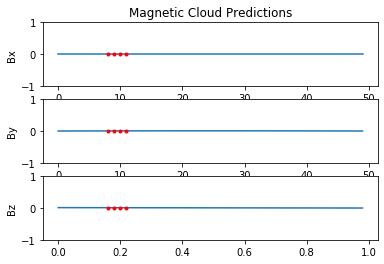

In [18]:
phi, theta, y0R, bx, by, bz = readCSV(csvPath,'fluxrope_10_90_0_0_1.txt')

b = np.sqrt( bx*bx + by*by + bz*bz )
bx, by, bz = normalizeVector(bx,by,bz,40.)

bx_seq = bx[0:n_steps_in]
by_seq = by[0:n_steps_in]
bz_seq = bz[0:n_steps_in]

in_seq1 = bx_seq.reshape((n_steps_in, 1))
in_seq2 = by_seq.reshape((n_steps_in, 1))
in_seq3 = bz_seq.reshape((n_steps_in, 1))
   
dataset = np.hstack((in_seq1,in_seq2,in_seq3))
dataset = dataset.reshape((1, n_steps_in, n_features))
yhat = model.predict(dataset, verbose=0)

n = bx.shape[0]
x = np.arange(0, n)

fillValues = np.full(n_steps_in,float('NaN'))
bx1 = np.concatenate( (fillValues, yhat[0,:,0]) )
by1 = np.concatenate( (fillValues, yhat[0,:,1]) )
bz1 = np.concatenate( (fillValues, yhat[0,:,2]) )

fillValues = np.full(len(x)-bx1.shape[0],float('NaN'))
bx1 = np.concatenate( (bx1, fillValues) )
by1 = np.concatenate( (by1, fillValues) )
bz1 = np.concatenate( (bz1, fillValues) )

plt.subplot(3, 1, 1)
plt.title('Magnetic Cloud Predictions')
plt.plot(x, bx)
plt.plot(x, bx1, color='red', marker='.', linestyle='None' )
plt.ylabel('Bx')
plt.ylim(-1,1)

plt.subplot(3, 1, 2)
plt.plot(x, by)
plt.plot(x, by1, color='red', marker='.', linestyle='None' )
plt.ylim(-1,1)
plt.ylabel('By')

plt.subplot(3, 1, 3)
plt.plot(x/n, bz)
plt.plot(x/n, bz1, color='red', marker='.', linestyle='None' )
plt.ylim(-1,1)
plt.ylabel('Bz')

In [20]:
by_seq

array([0.001875  , 0.00237479, 0.00285376, 0.0033119 , 0.00374922,
       0.00416571, 0.00456138, 0.00493622])

In [19]:
yhat[0,:,:]

array([[-3.0062050e-03,  7.2252862e-03,  5.1726783e-03],
       [-7.8715384e-04,  4.3954998e-03,  4.4372687e-03],
       [ 4.7177076e-05,  3.6855042e-03,  1.9367719e-03],
       [ 1.4363080e-03,  5.6662895e-03, -2.5619129e-03]], dtype=float32)

In [11]:
d ='/data/lstm/models/'
f = 'test_file_list.txt'

files1 = getFluxropes( d, f, 0, 25 ) # y0 [0,25]
files2 = getFluxropes( d, f, 30, 50 )     # y0 [30,50]
files3 = getFluxropes( d, f, 55, 75 )     # y0 [55,75]
files4 = getFluxropes( d, f, 80, 95 )         # y0 [80,95]

print("Fluxropes with Y0 [0,25]:",  len(files1))
print("Fluxropes with Y0 [30,50]:", len(files2))
print("Fluxropes with Y0 [55,75]:", len(files3))
print("Fluxropes with Y0 [80,95]:", len(files4))

Fluxropes with Y0 [0,25]: 51180
Fluxropes with Y0 [30,50]: 42699
Fluxropes with Y0 [55,75]: 42258
Fluxropes with Y0 [80,95]: 34214


### Make predications

In [12]:
def getMSE( d, fileList ):
    
    data = np.zeros( shape=(3, len(fileList)) )

    n = len(fileList)
    twentyFive = np.ceil(0.25 * n)
    fifty =      np.ceil(0.50 * n)
    seventyFve = np.ceil(0.75 * n)
    
    count = 0
    for file in fileList:
    
        if ( count == twentyFive ):
            print("25% complete...")
        if ( count == fifty ):
            print("50% complete...")
        if ( count == seventyFve ):
            print("75% complete...")
            
        file = d + file.rstrip("\n")
        phi, theta, y0R, bx, by, bz = readCSV(file)
    
        bx_seq = bx[0:n_steps_in]
        by_seq = by[0:n_steps_in]
        bz_seq = bz[0:n_steps_in]

        in_seq1 = bx_seq.reshape((n_steps_in, 1))
        in_seq2 = by_seq.reshape((n_steps_in, 1))
        in_seq3 = bz_seq.reshape((n_steps_in, 1))
   
        dataset = np.hstack((in_seq1,in_seq2,in_seq3))
        dataset = dataset.reshape((1, n_steps_in, n_features))
        yhat = model.predict(dataset, verbose=0)
    
        yhat = yhat.reshape(n_steps_out,3)

        y_actual = np.zeros( shape=(n_steps_out,3) )
        y_actual[:,0] = bx[n_steps_in:n_steps_in+n_steps_out]
        y_actual[:,1] = by[n_steps_in:n_steps_in+n_steps_out]
        y_actual[:,2] = bz[n_steps_in:n_steps_in+n_steps_out]
    
        mse = sklearn.metrics.mean_squared_error(y_actual, yhat)
    
        data[0,count] = phi
        data[1,count] = theta
        data[2,count] = mse
        
        count += 1
        
    return data


25% complete...
50% complete...
75% complete...


Text(0.5, 1.0, 'MSE y0 [0,25]')

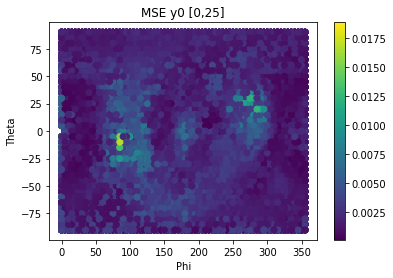

In [13]:
data = getMSE(csvPath,files1)
plt.scatter( data[0,:], data[1,:], c=data[2,:] )
plt.colorbar()
plt.xlabel('Phi')
plt.ylabel('Theta')
plt.title('MSE y0 [0,25]')

25% complete...
50% complete...
75% complete...


Text(0.5, 1.0, 'MSE y0 [30,50]')

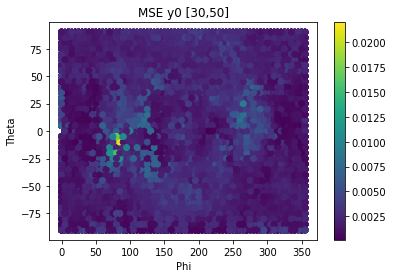

In [14]:
data = getMSE(csvPath,files2)
plt.scatter( data[0,:], data[1,:], c=data[2,:] )
plt.colorbar()
plt.xlabel('Phi')
plt.ylabel('Theta')
plt.title('MSE y0 [30,50]')

25% complete...
50% complete...
75% complete...


Text(0.5, 1.0, 'MSE y0 [55,75]')

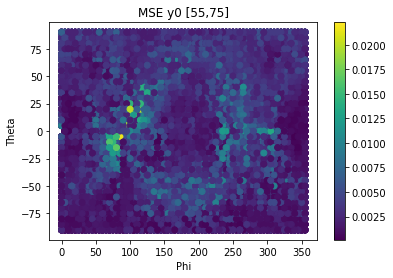

In [16]:
data = getMSE(csvPath, files3)
plt.scatter( data[0,:], data[1,:], c=data[2,:] )
plt.colorbar()
plt.xlabel('Phi')
plt.ylabel('Theta')
plt.title('MSE y0 [55,75]')

25% complete...
50% complete...
75% complete...


Text(0.5, 1.0, 'MSE y0 [80,95]')

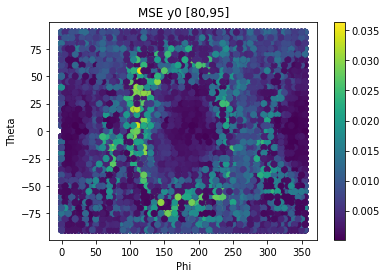

In [17]:
data = getMSE(csvPath, files4)
plt.scatter( data[0,:], data[1,:], c=data[2,:] )
plt.colorbar()
plt.xlabel('Phi')
plt.ylabel('Theta')
plt.title('MSE y0 [80,95]')